In [30]:
import math

In [31]:
class Value:
    """
    A class representing a scalar value with support for automatic differentiation.

    Methods:
    - __init__(self, data, _children=(), _op='', label=''): Initializes a Value object with data, gradient, and bookkeeping variables.
    - __repr__(self): Returns a string representation of the Value object.
    - __add__(self, other): Defines addition operation between two Value objects or a Value object and a scalar.
    - __mul__(self, other): Defines multiplication operation between two Value objects or a Value object and a scalar.
    - __pow__(self, other): Defines exponentiation operation of a Value object to a scalar power.
    - tanh(self): Applies the hyperbolic tangent activation function to the Value object.
    - exp(self): Applies the exponential function to the Value object.
    - relu(self): Applies the rectified linear unit (ReLU) activation function to the Value object.
    - sigmoid(self): Applies the sigmoid activation function to the Value object.
    - backward(self): Performs backpropagation to compute gradients of all connected Value objects.
    - __radd__(self, other): Defines reverse addition operation when the left operand is not a Value object.
    - __rmul__(self, other): Defines reverse multiplication operation when the left operand is not a Value object.
    - __neg__(self): Negates the Value object.
    - __sub__(self, other): Defines subtraction operation between two Value objects or a Value object and a scalar.
    - __rsub__(self, other): Defines reverse subtraction operation when the left operand is not a Value object.
    - __truediv__(self, other): Defines division operation between two Value objects or a Value object and a scalar.
    - __rtruediv__(self, other): Defines reverse division operation when the left operand is not a Value object.
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initializes a Value object.

        Args:
        - data: The scalar value of the object.
        - _children: A tuple containing the child Value objects that contributed to the current object's value.
        - _op: The operation symbol associated with the current object.
        - label: A label to identify the current object (optional).
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
   
    def __repr__(self):
        return f"Value(data={self.data})" 
    
    # The __add__() method defines the behavior of the + operator between two Value objects or a Value object and a scalar.
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        # Using the chain rule, the derivative of the final output (dF) with respect to the current child
        # is equal to the local derivative (d of parent with respect to child) times the dF with respect to its parent.
        # For example, c = a + b; dO/dA = dC/dA * dO/dC.

        def _backward():
            self.grad += 1.0 * out.grad  # dC/dA = 1.0, dO/dC = out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        """
        Defines multiplication operation between two Value objects or a Value object and a scalar.

        Args:
        - other: The Value object or scalar to multiply with.

        Returns:
        - out: A new Value object representing the result of the multiplication.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Defines exponentiation operation of a Value object to a scalar power.

        Args:
        - other: The scalar power to raise the Value object to.

        Returns:
        - out: A new Value object representing the result of the exponentiation.
        """
        assert isinstance(other, (int, float))  # Should be int or float
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        """
        Applies the hyperbolic tangent activation function to the Value object.

        Returns:
        - out: A new Value object representing the result of the tanh operation.
        """
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
            
        return out

    def exp(self):
        """
        Applies the exponential function to the Value object.

        Returns:
        - out: A new Value object representing the result of the exponential function.
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def log(self):
        """
        Calculates the natural logarithm of the Value object.

        Returns:
        - out: A new Value object representing the natural logarithm.
        """
        assert self.data > 0, "Value must be greater than 0 for logarithm operation"
        out = Value(math.log(self.data), (self,), 'log')

        def _backward():
            self.grad += (1 / self.data) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        """
        Applies the rectified linear unit (ReLU) activation function to the Value object.

        Returns:
        - out: A new Value object representing the result of the ReLU operation.
        """
        out = Value(max(0, self.data), (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def sigmoid(self):
        """
        Applies the sigmoid activation function to the Value object.

        Returns:
        - out: A new Value object representing the result of the sigmoid operation.
        """
        s = 1 / (1 + math.exp(-self.data))
        out = Value(s, (self,), 'sigmoid')

        def _backward():
            self.grad += (s * (1 - s)) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        """
        Performs backpropagation to compute gradients of all connected Value objects.
        """
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    # For binary output with one neuron only
    def neg_log_loss(self, y):
        """
        Calculates the negative log loss (binary cross-entropy loss).

        Args:
        - y: The true label (0 or 1).
        - self: The predicted probability of the positive class.

        Returns:
        - out: A new Loss object representing the negative log loss.
        """
        assert y in [0, 1], "True label must be 0 or 1"
        assert 0 <= self.data <= 1, "Predicted probability must be between 0 and 1"

        loss = -(y * math.log(self.data) + (1 - y) * math.log(1 - self.data))
        out = Value(loss, (self,), 'neg_log_loss')

        def _backward():
            self.grad = (self.data - y)  # dLoss/dp
        out._backward = _backward

        return out

    def __radd__(self, other):
        """
        Defines reverse addition operation when the left operand is not a Value object.

        Args:
        - other: The Value object or scalar that is being added to the Value object.

        Returns:
        - out: A new Value object representing the result of the reverse addition.
        """
        return self + other

    def __rmul__(self, other):
        """
        Defines reverse multiplication operation when the left operand is not a Value object.

        Args:
        - other: The Value object or scalar that is being multiplied with the Value object.

        Returns:
        - out: A new Value object representing the result of the reverse multiplication.
        """
        return self * other
    
    def __neg__(self):
        """
        Negates the Value object.

        Returns:
        - out: A new Value object representing the negation of the original Value object.
        """
        return self * -1

    def __sub__(self, other):
        """
        Defines subtraction operation between two Value objects or a Value object and a scalar.

        Args:
        - other: The Value object or scalar to subtract from the Value object.

        Returns:
        - out: A new Value object representing the result of the subtraction.
        """
        return self + (-other)

    def __rsub__(self, other):
        """
        Defines reverse subtraction operation when the left operand is not a Value object.

        Args:
        - other: The Value object or scalar that is being subtracted from the Value object.

        Returns:
        - out: A new Value object representing the result of the reverse subtraction.
        """
        other = other if isinstance(other, Value) else Value(other)
        return other - self

    def __truediv__(self, other):
        """
        Defines division operation between two Value objects or a Value object and a scalar.

        Args:
        - other: The Value object or scalar to divide the Value object by.

        Returns:
        - out: A new Value object representing the result of the division.
        """
        return self * other**(-1)
    
    def __rtruediv__(self, other):
        """
        Defines reverse division operation when the left operand is not a Value object.

        Args:
        - other: The Value object or scalar that is being divided by the Value object.

        Returns:
        - out: A new Value object representing the result of the reverse division.
        """
        other = other if isinstance(other, Value) else Value(other)
        return other * self**(-1)

In [32]:
a = Value(2.0)
b = Value(4.0)
d = a + b

In [33]:
x = Value(2.0)
y = x.log()
y.backward()

print(x.grad)  # Output: 0.5

0.5


### Let there result of the operation know about its children

In order to let "__add__" or other operation know about its children, the parameter (self, other is added).

Example:
<code>result = a + b</code>

This will call a.__add__(b) which will result to creating an object Value((a.data + b.data), (a, b)) where self is the "a" object and "b" is the other object.

The operation <code>Value((a.data + b.data), (a, b))</code> will call its __init__ function which is:
        self.data = data
        self._prev = set(_children)

By calling the <code>result._prev</code>, it will return its _children "a" and "b" which are the previous objects.

In [34]:
d._prev

{Value(data=2.0), Value(data=4.0)}

### Let there result which immediate operation was used by its children

In order to let the result object of the operations know which operation was utilized (ex:<code> a.__add__(b) </code>), another argument "+" is passed:

<code>out = Value(self.data + other.data, (self, other), "+")</code>

Then, <code>result._op</code> will return <code>+</code>.

In [35]:
d._op

'+'

### Let us visualize the result

In [36]:
from graphviz import Digraph

def trace(root):
    # Creates a set of nodes and edges that will be passed to the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root) #1
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### Explanation
By calling <code>trace(d)</code> which is the result of the operation <code>d = a * b + c</code>, <code>build(d)</code> is triggered.

The function <code>build(v)</code> accepts <code>d</code> as the parameter, and check and appends it to the set "nodes" if it is not present.

Then, the loop in <code>for child in v._prev:</code> is triggered by getting the children of "d": <code>d._prev</code>. Then the set (child, v) in this case, <code>(a, d)</code> and <code>(b, d)</code> are appended on the "edges". The <code>build(child)</code> function is called to run and process the nodes and adges for the children of the current child.

In [37]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x1w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

model = x1w1x2w2 + b; model.label = 'n'
o = model.tanh(); o.label = 'o'
o.backward()

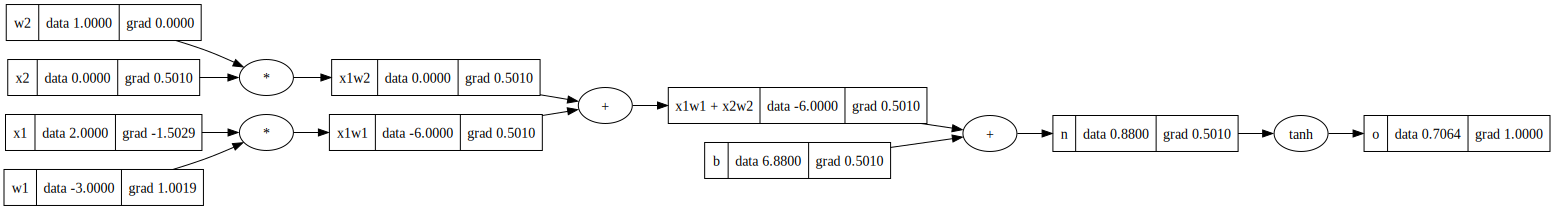

In [38]:
draw_dot(o)

In [39]:
import random

class Neuron:
    """
    A class representing a neuron in a neural network.

    Methods:
    - __init__(self, nin, activation=None): Initializes a Neuron object with random weights and bias.
    - __call__(self, x): Performs the forward pass computation of the neuron given an input and activation function.
    - parameters(self): Returns a list of the neuron's parameters (weights and bias).
    """

    def __init__(self, n_inputs, activation=None):
        """
        Initializes a Neuron object.

        Args:
        - nin (int): The number of input connections to the neuron.
        - activation (str): The activation function for the neuron (default: None).
                            Should be one of the following: 'relu', 'sigmoid', 'tanh'.
        """
        self.w = [Value(random.uniform(-1, 0.5)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1, 0.5))
        self.label = None

        # Define the activation functions as a dictionary mapping activation names to corresponding functions
        self.activations = {
            'relu': Value.relu,
            'sigmoid': Value.sigmoid,
            'tanh': Value.tanh
        }

        assert activation in self.activations or activation is None, f"Invalid activation: {activation}"
        self.activation = activation

    def __call__(self, x):
        """
        Performs the forward pass computation of the neuron given an input and activation function.

        Args:
        - x: The input value or a list of input values.

        Returns:
        - The result of the forward pass computation.
        """
        x = x if isinstance(x, list) else [x]
        weighted_sum = sum([w_i * x_i for w_i, x_i in zip(self.w, x)]) + self.b

        if self.activation is None:
            return weighted_sum
        else:
            activation_func = self.activations[self.activation]
            return activation_func(weighted_sum)

    def parameters(self):
        """
        Returns a list of the neuron's parameters (weights and biases).
        """
        return self.w + [self.b]


class Layer:
    """
    A class representing a layer in a neural network.

    Methods:
    - __init__(self, nin, nout, activation): Initializes a Layer object.
    - __call__(self, x): Performs the forward pass computation of the layer given an input and activation function.
    - parameters(self): Returns a list of the layer's parameters (weights and biases of all neurons).
    """

    def __init__(self, nin, nout, activation):
        """
        Initializes a Layer object.

        Args:
        - nin (int): The number of input connections to each neuron in the layer.
        - nout (int): The number of neurons in the layer.
        - activation (str): The activation function for the neurons in the layer.
                            Should be one of the following: 'relu', 'sigmoid', 'tanh'.
        """
        self.neurons = [Neuron(nin, activation) for _ in range(nout)]

    def __call__(self, x):
        """
        Performs the forward pass computation of the layer given an input and activation function.

        Args:
        - x: The input to the layer.

        Returns:
        - The output of the layer.
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        """
        Returns a list of the layer's parameters (weights and biases of all neurons).
        """
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    """
    A class representing a Multi-Layer Perceptron (MLP) neural network.

    Methods:
    - __init__(self, nin, nouts): Initializes an MLP object.
    - __call__(self, x): Performs the forward pass computation of the MLP given an input.
    - parameters(self): Returns a list of all parameters in the MLP (weights and biases of all neurons in all layers).
    - predict(self, x): Generates predictions for the given input.

    Example usage:
    ```
    model = MLP(nin=10, nouts=[(20, 'relu'), (10, 'sigmoid')])
    output = model(input_data)
    ```
    """

    def __init__(self, n_input, layers_config):
        """
        Initializes an MLP object.

        Args:
        - n_input (int): The number of input neurons.
        - layers_config (list): A list of tuples specifying the number of neurons and activation function for each layer.
                        Each tuple should contain two elements: (n_neurons, activation).
        """
        sz = [n_input] + [n[0] if isinstance(n, tuple) else n for n in layers_config]
        self.layers = [Layer(sz[i], sz[i+1], n[1] if isinstance(n, tuple) and len(n) > 1 else None) for i, n in enumerate(layers_config)]
        self.add_labels()

    def __call__(self, x):
        """
        Performs the forward pass computation of the MLP given an input.

        Args:
        - x: The input to the MLP.

        Returns:
        - The output of the MLP.
        """
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """
        Returns a list of all parameters in the MLP (weights and biases of all neurons in all layers).
        """
        return [p for layer in self.layers for p in layer.parameters()]
    
    def add_labels(self):
        """
        Adds labels to for each neuron of each layer of the model.
        """
        for i, layer in enumerate(self.layers):
            for j, n in enumerate(layer.neurons):
                n.label = f"L{i}N{j}"

    def predict(self, x):
        """
        Generates predictions for the given input.

        Args:
        - x: The input data. It must be a list of list of the input features.

        Returns:
        - The predictions of the MLP.
        """
        return [self(i) for i in x]
    
    def __repr__(self):
        return f"MLP of {len(self.layers)} layers [{', '.join(str(layer) for layer in self.layers)}]"


In [40]:
model = MLP(3, [(4, 'tanh'), (4, 'tanh'), (1, 'tanh')])

In [41]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [42]:
def train_model(model, features, actuals, epoch, lr, batch_size=0):
    for k in range(epoch):
        # Initialize variables for accumulating gradients and losses
        epoch_loss = []

        batch_size = batch_size if batch_size != 0 else len(actuals)

        # Iterate over the dataset in batches
        for start in range(0, len(xs), batch_size):
            end = start + batch_size
            batch_xs = features[start:end]
            batch_ys = actuals[start:end]

            # Forward pass
            ypred = [model(x) for x in batch_xs]
            loss = sum([(y - y_p)**2 for y, y_p in zip(batch_ys, ypred)])
            loss = loss if isinstance(loss, Value) else Value(loss)

            # Backward pass
            for p in model.parameters():
                p.grad = 0
            loss.backward()

            # Update parameters within the batch
            for p in model.parameters():
                p.data -= lr * p.grad

            # Accumulate loss
            epoch_loss.append(loss.data / batch_size)

        # Print average loss for the epoch
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        print(k, avg_loss)

        # Clear gradients after each epoch
        for p in model.parameters():
            p.grad = 0


In [43]:
train_model(model, xs, ys, epoch=20, lr=0.05)

0 1.6917456726780338
1 1.3845995368956274
2 0.8745215401061567
3 0.5765380679581124
4 0.3750504240869568
5 0.24357631389394294
6 0.15338565424581682
7 0.11334027574326305
8 0.08957730143891729
9 0.0733796718993942
10 0.06176600554576671
11 0.05309817224716779
12 0.046417093377732664
13 0.041130371319917536
14 0.036855187660668164
15 0.033334521160792635
16 0.030390102929324384
17 0.027894785148271282
18 0.025755663555464978
19 0.023903409155700567


In [44]:
model.predict(xs)

[Value(data=0.8433079464631521),
 Value(data=-0.866773590964777),
 Value(data=-0.8438148413182934),
 Value(data=0.850180790725068)]

In [45]:
model.predict([[100.0, 100.0, -1.0]])

[Value(data=0.8574988447725608)]